# Frontmatter

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
# Define font properties
font = {
    'family': 'sans-serif',  # Use sans-serif family
    'sans-serif': ['Helvetica'],  # Specify Helvetica as the sans-serif font
    'size': 14  # Set the default font size
}
plt.rc('font', **font)

# Set tick label sizes
plt.rc('ytick', labelsize=24)
plt.rc('xtick', labelsize=24)

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "Helvetica"
})
# Customize axes spines and legend appearance
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['legend.frameon'] = False


%load_ext autoreload
%autoreload 2
    
from dwMRI_BasicFuncs import *
from tqdm.auto import tqdm

In [2]:
network_path = './Networks/'
image_path   = '../Figures/'
if not os.path.exists(image_path):
    os.makedirs(image_path)
NoiseLevels = [None,20,10,5,2]

TrainingSamples = 50000
InferSamples    = 500

lower_abs,upper_abs = -0.07,0.07
lower_rest,upper_rest = -0.015,0.015
lower_S0 = 25
upper_S0 = 2000
Save = True

TrueCol  = 'k'
NoisyCol = 'k'
WLSFit   = 'sandybrown'#np.array([225,190,106])/255
SBIFit   = np.array([64,176,166])/255

Errors_name = ['MD comparison','FA comparison','eig. comparison','Frobenius','Signal comparison','Correlation','Signal comparison','Correlation2']
custom_prior = DTIPriorS0(lower_abs,upper_abs,lower_rest,upper_rest,lower_S0,upper_S0)
priorS0, *_ = process_prior(custom_prior) 

/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/sbi/utils/user_input_checks_utils.py:389: UserWarning: No prior bounds were passed, consider passing lower_bound
            and / or upper_bound if your prior has bounded support.
  warnings.warn(
/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/sbi/utils/user_input_checks_utils.py:69: UserWarning: Prior is lacking mean attribute, estimating prior mean from samples.
  warnings.warn(
/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/sbi/utils/user_input_checks_utils.py:80: UserWarning: Prior is lacking variance attribute, estimating prior variance from
                samples...
  warnings.warn(


## Plotting

In [3]:
def viol_plot(A,col,hatch=False,**kwargs):
    A_T = np.transpose(A)
    filtered_A = []
    for column in A_T:
        # Remove NaNs
        column = column[~np.isnan(column)]
        # Identify outliers using Z-score
        z_scores = stats.zscore(column)
        abs_z_scores = np.abs(z_scores)
        # Filter data within 3 standard deviations
        filtered_entries = (abs_z_scores < 1000)
        filtered_column = column[filtered_entries]
        filtered_A.append(filtered_column)
    
    vp = plt.violinplot(filtered_A,showmeans=True,**kwargs)  
    for v in vp['bodies']:
        v.set_facecolor(col)
    vp['cbars'].set_color(col)
    vp['cmins'].set_color(col)
    vp['cmaxes'].set_color(col)
    vp['cmeans'].set_color('black')
    if(hatch):
        vp['bodies'][0].set_hatch('//')

def box_plot(data, edge_color, fill_color, hatch=None, linewidth=1.5, **kwargs):
    # Clean data to remove NaNs column-wise
    if(np.ndim(data) == 1):
        cleaned_data = data[~np.isnan(data)]
    else:
        cleaned_data = [d[~np.isnan(d)] for d in data]
    # Create the box plot with cleaned data
    bp = plt.boxplot(cleaned_data, patch_artist=True, **kwargs)
    
    for element in ['boxes', 'whiskers', 'means', 'medians', 'caps']:
        plt.setp(bp[element], color=edge_color, linewidth=linewidth)
    for patch in bp['boxes']:
        patch.set(facecolor=fill_color, linewidth=linewidth)      
        if hatch is not None:
            patch.set(hatch=hatch)

    return bp

In [4]:
def BoxPlots(y_data, positions, colors, colors2, ax,hatch = False,scatter=False,scatter_alpha=0.5, **kwargs):

    GREY_DARK = "#747473"
    jitter = 0.02
    # Clean data to remove NaNs column-wise
    if(np.ndim(y_data) == 1):
        cleaned_data = y_data[~np.isnan(y_data)]
    else:
        cleaned_data = [d[~np.isnan(d)] for d in y_data]
    
    # Define properties for the boxes (patch objects)
    boxprops = dict(
        linewidth=2, 
        facecolor='none',       # use facecolor for filling (set to 'none' if you want no fill)
        edgecolor='turquoise'   # edgecolor for the outline
    )

    # Define properties for the medians (Line2D objects)
    # Ensure GREY_DARK is defined (or replace it with a color string)
    medianprops = dict(
        linewidth=2, 
        color=GREY_DARK,
        solid_capstyle="butt"
    )

    # For whiskers, since they are Line2D objects, use 'color'
    whiskerprops = dict(
        linewidth=2, 
        color='turquoise'
    )

    bplot = ax.boxplot(
        cleaned_data,
        positions=positions, 
        showfliers=False,
        showcaps = False,
        medianprops=medianprops,
        whiskerprops=whiskerprops,
        boxprops=boxprops,
        patch_artist=True,
        **kwargs
    )

    # Update the color of each box (these are patch objects)
    for i, box in enumerate(bplot['boxes']):
        box.set_edgecolor(colors[i])
        if(hatch):
            box.set_hatch('/')
    
    
    # Update the color of the whiskers (each box has 2 whiskers)
    for i in range(len(positions)):
        bplot['whiskers'][2*i].set_color(colors[i])
        bplot['whiskers'][2*i+1].set_color(colors[i])
    
    # If caps are enabled, update their color (Line2D objects)
    if 'caps' in bplot:
        for i, cap in enumerate(bplot['caps']):
            cap.set_color(colors[i//2])  # two caps per box

    if(scatter):
        if(np.ndim(cleaned_data) == 1):
            x_data = np.array([positions] * len(cleaned_data))
            x_jittered = x_data + stats.t(df=6, scale=jitter).rvs(len(x_data))
            ax.scatter(x_data, cleaned_data, s=100, color=colors2, alpha=scatter_alpha)
        else:
            x_data = [np.array([positions[i]] * len(d)) for i, d in enumerate(cleaned_data)]
            x_jittered = [x + stats.t(df=6, scale=jitter).rvs(len(x)) for x in x_data]
            # Plot the scatter points with jitter (using colors2)
            for x, y, c in zip(x_jittered, cleaned_data, colors2):
                ax.scatter(x, y, s=100, color=c, alpha=scatter_alpha)

# DKI fits

In [5]:

i = 1
fdwi = './HCP_data/Pat'+str(i)+'/diff_1k.nii.gz'
bvalloc = './HCP_data/Pat'+str(i)+'/bvals_1k.txt'
bvecloc = './HCP_data/Pat'+str(i)+'/bvecs_1k.txt'

fdwi3 = './HCP_data/Pat'+str(i)+'/diff_3k.nii.gz'
bvalloc3 = './HCP_data/Pat'+str(i)+'/bvals_3k.txt'
bvecloc3 = './HCP_data/Pat'+str(i)+'/bvecs_3k.txt'

bvalsHCP = np.loadtxt(bvalloc)
bvecsHCP = np.loadtxt(bvecloc)
gtabHCP = gradient_table(bvalsHCP, bvecsHCP)

bvalsHCP3 = np.loadtxt(bvalloc3)
bvecsHCP3 = np.loadtxt(bvecloc3)
gtabHCP3 = gradient_table(bvalsHCP3, bvecsHCP3)

gtabExt  = gradient_table(np.hstack((bvalsHCP,bvalsHCP3)), np.vstack((bvecsHCP,bvecsHCP3)))

data, affine, img = load_nifti(fdwi, return_img=True)
data, affine = reslice(data, affine, (1.5,1.5,1.5), (2.5,2.5,2.5))
axial_middle = data.shape[2] // 2
maskdata, mask = median_otsu(data, vol_idx=range(10, 50), median_radius=3,
                             numpass=1, autocrop=False, dilate=2)

data3, affine, img = load_nifti(fdwi3, return_img=True)
data3, affine = reslice(data3, affine, (1.5,1.5,1.5), (2.5,2.5,2.5))
# Get the indices of True values
true_indices = np.argwhere(mask)

# Determine the minimum and maximum indices along each dimension
min_coords = true_indices.min(axis=0)
max_coords = true_indices.max(axis=0)

maskdata  = maskdata[min_coords[0]:max_coords[0]+1,min_coords[1]:max_coords[1]+1,min_coords[2]:max_coords[2]+1]
maskdata3 = data3[min_coords[0]:max_coords[0]+1,min_coords[1]:max_coords[1]+1,min_coords[2]:max_coords[2]+1]

TestData = np.concatenate([maskdata[:, :, axial_middle, :],maskdata3[:, :, axial_middle, :]],axis=-1)
FlatTD = TestData.reshape(maskdata.shape[0]*maskdata.shape[1],138)
FlatTD = FlatTD[FlatTD[:,:69].sum(axis=-1)>0]
FlatTD = FlatTD[~np.array(FlatTD<0).any(axis=-1)]

dkimodel = dki.DiffusionKurtosisModel(gtabExt)
tenfit = dkimodel.fit(FlatTD)
DKIHCP = tenfit.kt
DTIHCP = tenfit.lower_triangular()
DKIFull = np.array(DKIHCP)
DTIFull = np.array(DTIHCP)


DTIFilt1 = DTIFull[(abs(DKIFull)<10).all(axis=1)]
DKIFilt1 = DKIFull[(abs(DKIFull)<10).all(axis=1)]
DTIFilt = DTIFilt1[(DKIFilt1>-3/7).all(axis=1)]
DKIFilt = DKIFilt1[(DKIFilt1>-3/7).all(axis=1)]

TrueMets = []
FA       = []
for (dt,kt) in tqdm(zip(DTIFilt,DKIFilt)):
    TrueMets.append(DKIMetrics(dt,kt))
    FA.append(FracAni(np.linalg.eigh(vals_to_mat(dt))[0],np.mean(np.linalg.eigh(vals_to_mat(dt))[0])))
TrueMets = np.array(TrueMets)
TrueFA = np.array(FA)

100%|█████████████████████████████████████| 2578/2578 [00:00<00:00, 9237.96it/s]


0it [00:00, ?it/s]

In [6]:
# Full fit
DT1_full,DT2_full = FitDT(DTIFilt,1)
x4_full,R1_full,x2_full,R2_full = FitKT(DKIFilt,1)

# LowFA Fit
DT1_lfa,DT2_lfa = FitDT(DTIFilt[TrueMets[:,-1]<0.3,:],1)
x4_lfa,R1_lfa,x2_lfa,R2_lfa = FitKT(DKIFilt[TrueMets[:,-1]<0.3,:],1)

# HighFA Fit
DT1_hfa,DT2_hfa = FitDT(DTIFilt[TrueMets[:,-1]>0.7,:],1)
x4_hfa,R1_hfa,x2_hfa,R2_hfa = FitKT(DKIFilt[TrueMets[:,-1]>0.7,:],1)

# UltraLowFA Fit
DT1_ulfa,DT2_ulfa = FitDT(DTIFilt[TrueMets[:,-1]<0.1,:],1)
x4_ulfa,R1_ulfa,x2_ulfa,R2_ulfa = FitKT(DKIFilt[TrueMets[:,-1]<0.1,:],1)

# HigherAK Fit
DT1_hak,DT2_hak = FitDT(DTIFilt[TrueMets[:,1]>0.9,:],1)
x4_hak,R1_hak,x2_hak,R2_hak = FitKT(DKIFilt[TrueMets[:,1]>0.9,:],1)

/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:6547: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


# Figure 2

In [7]:
FigLoc = image_path + 'Fig_2/'
if not os.path.exists(FigLoc):
    os.makedirs(FigLoc)

In [8]:
fimg_init, fbvals, fbvecs = get_fnames('small_64D')
bvals, bvecs = read_bvals_bvecs(fbvals, fbvecs)
hsph_initial = HemiSphere(xyz=bvecs[1:])
hsph_initial20 = HemiSphere(xyz=bvecs[1:20])
hsph_initial7 = HemiSphere(xyz=bvecs[1:7])
hsph_updated,potentials = disperse_charges(hsph_initial,5000)
hsph_updated20,potentials = disperse_charges(hsph_initial20,5000)
hsph_updated7,potentials = disperse_charges(hsph_initial7,5000)

gtabSimF = gradient_table(np.array([0]+[1000]*64).squeeze(), np.vstack([[0,0,0],hsph_updated.vertices]))
gtabSim20 = gradient_table(np.array([0]+[1000]*19).squeeze(), np.vstack([[0,0,0],hsph_updated20.vertices]))
gtabSim7 = gradient_table(np.array([0]+[1000]*6).squeeze(), np.vstack([[0,0,0],hsph_updated7.vertices]))

In [9]:
np.random.seed(1)

gTabs = [gtabSimF]
for _ in range(4):
    x = np.random.permutation(np.arange(65))
    bvecs_shuffle = gtabSimF.bvecs[x]
    bvals_shuffle = gtabSimF.bvals[x]
    
    gTabs.append(gradient_table(bvals_shuffle, bvecs_shuffle))

In [10]:
torch.manual_seed(0)
np.random.seed(0)

params = priorS0.sample()
dtTruth = ComputeDTI(params)
dtTruth = ForceLowFA(dtTruth)
Truth = CustomSimulator(dtTruth,gtabSimF,S0=200,snr=None)

    
dt_evals,dt_evecs = np.linalg.eigh(dtTruth)

SNR = [CustomSimulator(dtTruth,gtabSimF, S0=200,snr=scale) for scale in NoiseLevels[1:]]
    
SNR = np.array(SNR)

## a

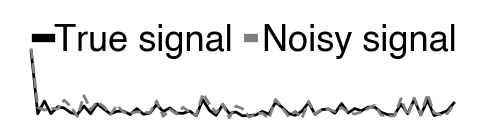

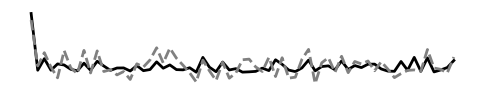

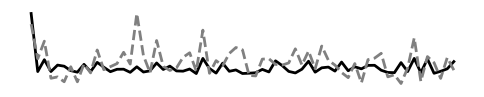

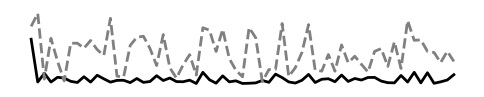

In [11]:
plt.subplots(figsize=(6,1))
plt.plot(Truth,'k',lw=2,label='True signal')
plt.plot(SNR[0],'gray',lw=2,ls='--',label='Noisy signal')
plt.axis('off')
legend= plt.legend(ncols=2,loc=1,bbox_to_anchor =  (1.03,1.7),fontsize=26,columnspacing=0.3,handlelength=0.4,handletextpad=0.1)
for handle in legend.get_lines():
    handle.set_linewidth(6)  # Set desired linewidth
if Save: plt.savefig(FigLoc+'EgSig20.pdf',format='pdf',bbox_inches='tight',transparent=True)
plt.show()
plt.subplots(figsize=(6,1))
plt.plot(Truth,'k',lw=2)
plt.plot(SNR[1],'gray',lw=2,ls='--')
plt.axis('off')
if Save: plt.savefig(FigLoc+'EgSig10.pdf',format='pdf',bbox_inches='tight',transparent=True)
plt.show()
plt.subplots(figsize=(6,1))
plt.plot(Truth,'k',lw=2)
plt.plot(SNR[2],'gray',lw=2,ls='--')
plt.axis('off')
if Save: plt.savefig(FigLoc+'EgSig5.pdf',format='pdf',bbox_inches='tight',transparent=True)
plt.show()
plt.subplots(figsize=(6,1))
plt.plot(Truth,'k',lw=2)
plt.plot(SNR[3],'gray',lw=2,ls='--')
plt.axis('off')
if Save: plt.savefig(FigLoc+'EgSig2.pdf',format='pdf',bbox_inches='tight',transparent=True)
plt.show()

## b 

In [12]:
np.random.seed(13)
SNR20 = np.vstack([CustomSimulator(dtTruth,gtabSimF, S0=200,snr=20) for k in range(100)])
SNR10 = np.vstack([CustomSimulator(dtTruth,gtabSimF, S0=200,snr=10) for k in range(100)])
SNR5 = np.vstack([CustomSimulator(dtTruth,gtabSimF, S0=200,snr=5) for k in range(100)])
SNR2 = np.vstack([CustomSimulator(dtTruth,gtabSimF, S0=200,snr=2) for k in range(100)])


In [13]:
tenmodel = dti.TensorModel(gtabSimF,return_S0_hat = True,fit_method='NLLS')
tenfit = tenmodel.fit(SNR20)
FA20 = dti.fractional_anisotropy(tenfit.evals)
MD20 = dti.mean_diffusivity(tenfit.evals)
tenfit = tenmodel.fit(SNR10)
FA10 = dti.fractional_anisotropy(tenfit.evals)
MD10 = dti.mean_diffusivity(tenfit.evals)
tenfit = tenmodel.fit(SNR5)
FA5 = dti.fractional_anisotropy(tenfit.evals)
MD5 = dti.mean_diffusivity(tenfit.evals)
tenfit = tenmodel.fit(SNR2)
FA2 = dti.fractional_anisotropy(tenfit.evals)
MD2 = dti.mean_diffusivity(tenfit.evals)

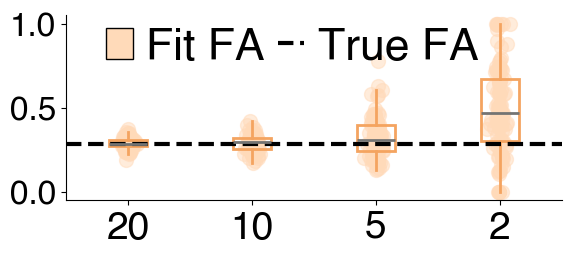

In [14]:
fig,ax = plt.subplots(figsize=(6.4,2.4))
y_data = np.array([FA20,FA10,FA5,FA2])
g_pos = np.array([1,2,3,4])
colors = ['sandybrown','sandybrown','sandybrown','sandybrown']
colors2 = ['peachpuff','peachpuff','peachpuff','peachpuff']

BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.3,scatter=True)
l = plt.axhline(FracAni(dt_evals,np.mean(dt_evals)),c='k',lw=3,ls='--',label='True FA')
plt.xticks([1,2,3,4],[20,10,5,2],fontsize=28)
plt.xticks(fontsize=28)#
#plt.xlabel('SNR',fontsize=32)
#plt.ylabel('FA',fontsize=32)
legend_elements = [
    mpatches.Patch(facecolor='peachpuff', edgecolor='k', label='Fit FA'),
    Line2D([0], [0], color='k', lw=3, ls='--', label='True FA')
]
plt.legend(handles=legend_elements,loc = 'lower left',bbox_to_anchor=(0.0,0.5),
           fontsize=32,columnspacing=0.3,handlelength=0.6,handletextpad=0.3,ncols=2)
plt.yticks([0,0.5,1])
if Save: plt.savefig(FigLoc+'EgNoiseFA.pdf',format='pdf',bbox_inches='tight',transparent=True)
plt.show()

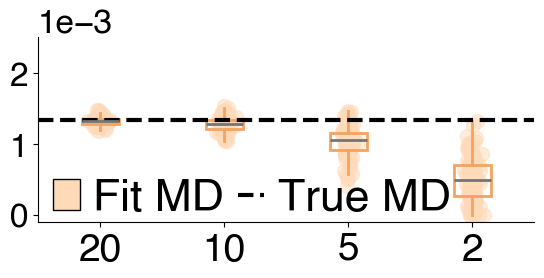

In [15]:
fig,ax = plt.subplots(figsize=(6.4,2.4))
y_data = np.array([MD20,MD10,MD5,MD2])
g_pos = np.array([1,2,3,4])
colors = ['sandybrown','sandybrown','sandybrown','sandybrown']
colors2 = ['peachpuff','peachpuff','peachpuff','peachpuff']

BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.3,scatter=True)
l = plt.axhline(np.mean(dt_evals),c='k',lw=3,ls='--',label='True MD')
plt.xticks([1,2,3,4],[20,10,5,2],fontsize=28)
plt.xticks(fontsize=28)
legend_elements = [
    mpatches.Patch(facecolor='peachpuff', edgecolor='k', label='Fit MD'),
    Line2D([0], [0], color='k', lw=3, ls='--', label='True MD')
]
plt.legend(handles=legend_elements,loc = 'lower left',bbox_to_anchor=(-0.05,-0.2),
           fontsize=32,columnspacing=0.3,handlelength=0.6,handletextpad=0.3,ncols=2)
plt.yticks([0,0.001,0.002])
plt.ylim((-0.0001, 0.0025))
plt.gca().ticklabel_format(axis='y',style='sci',scilimits=(-1,1))
if Save: plt.savefig(FigLoc+'EgNoiseMD.pdf',format='pdf',bbox_inches='tight',transparent=True)

In [16]:
np.random.seed(1)
torch.manual_seed(1)
if os.path.exists(f"{network_path}/DTISimFull.pickle"):
    with open(f"{network_path}/DTISimFull.pickle", "rb") as handle:
        posteriorFull = pickle.load(handle)
else:
    Obs = []
    Par = []
    for i in tqdm(range(TrainingSamples)):
        params = priorNoise.sample()
        dt = ComputeDTI(params)
        dt = ForceLowFA(dt)
        a = params[-1]
        Obs.append(CustomSimulator(dt,gtabSimF,200,a))
        Par.append(np.hstack([mat_to_vals(dt),a]))
    
    Obs = np.array(Obs)
    Par = np.array(Par)
    Obs = torch.tensor(Obs).float()
    Par = torch.tensor(Par).float()
    
    # Create inference object. Here, NPE is used.
    inference = SNPE(prior=priorNoise)
    
    # generate simulations and pass to the inference object
    inference = inference.append_simulations(Par, Obs)
    
    # train the density estimator and build the posterior
    density_estimator = inference.train()
    posteriorFull = inference.build_posterior(density_estimator)
    if not os.path.exists(f"{network_path}/DTISimFull.pickle"):
        with open(f"{network_path}/DTISimFull.pickle", "wb") as handle:
            pickle.dump(posteriorFull, handle)

In [17]:
np.random.seed(0)
torch.manual_seed(0)
Samples  = []
DTISim = []
S0Sim    = []

params = priorS0.sample([5000])
for i in tqdm(range(5000)):
    dt = ComputeDTI(params[i])
    dt = ForceLowFA(dt)
    DTISim.append(dt)
    S0Sim.append(params[i,-1])
    Samples.append([CustomSimulator(dt,gtabSimF, S0=200,snr=scale) for scale in NoiseLevels])
    
Samples = np.array(Samples).squeeze()
Samples = np.moveaxis(Samples, 0, -1)

Samples20  = []
DTISim20 = []
S0Sim20    = []

params = priorS0.sample([5000])
for i in tqdm(range(5000)):
    dt = ComputeDTI(params[i])
    dt = ForceLowFA(dt)
    DTISim20.append(dt)
    S0Sim20.append(params[i,-1])
    Samples20.append([CustomSimulator(dt,gtabSim20, S0=200,snr=scale) for scale in NoiseLevels])
    
Samples20 = np.array(Samples20).squeeze()
Samples20 = np.moveaxis(Samples20, 0, -1)

Samples7  = []
DTISim7 = []
S0Sim7    = []

params = priorS0.sample([5000])
for i in tqdm(range(5000)):
    dt = ComputeDTI(params[i])
    dt = ForceLowFA(dt)
    DTISim7.append(dt)
    S0Sim7.append(params[i,-1])
    Samples7.append([CustomSimulator(dt,gtabSim7, S0=200,snr=scale) for scale in NoiseLevels])
    
Samples7 = np.array(Samples7).squeeze()
Samples7 = np.moveaxis(Samples7, 0, -1)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

In [18]:
i = 1
j = 20
gT = gtabSimF
dT = DTISim[j]
tObs = CustomSimulator(dT,gT,200,None)

In [19]:
torch.manual_seed(2)
np.random.seed(2)
MD20_SBI = []
FA20_SBI = []
for S in tqdm(SNR20):
    posterior_samples_1 = posteriorFull.sample((InferSamples,), x=S,show_progress_bars=False)
    Guess = vals_to_mat(posterior_samples_1.mean(axis=0))
    Guess_clean = clip_negative_eigenvalues(Guess)
    evals_guess_raw,evecs_guess = np.linalg.eigh(Guess_clean)
    MD20_SBI.append(np.mean(evals_guess_raw))
    FA20_SBI.append(FracAni(evals_guess_raw,MD20_SBI[-1]))

torch.manual_seed(2)
np.random.seed(2)
MD10_SBI = []
FA10_SBI = []
for S in tqdm(SNR10):
    posterior_samples_1 = posteriorFull.sample((InferSamples,), x=S,show_progress_bars=False)
    Guess = vals_to_mat(posterior_samples_1.mean(axis=0))
    Guess_clean = clip_negative_eigenvalues(Guess)
    evals_guess_raw,evecs_guess = np.linalg.eigh(Guess_clean)
    if((evals_guess_raw<0).any()): print(True)
    MD10_SBI.append(np.mean(evals_guess_raw))
    FA10_SBI.append(FracAni(evals_guess_raw,MD10_SBI[-1]))

torch.manual_seed(2)
np.random.seed(2)
MD5_SBI = []


FA5_SBI = []
for S in tqdm(SNR5):
    posterior_samples_1 = posteriorFull.sample((InferSamples,), x=S,show_progress_bars=False)
    Guess = vals_to_mat(posterior_samples_1.mean(axis=0))
    Guess_clean = clip_negative_eigenvalues(Guess)
    evals_guess_raw,evecs_guess = np.linalg.eigh(Guess_clean)
    if((evals_guess_raw<0).any()): print(True)
    MD5_SBI.append(np.mean(evals_guess_raw))
    FA5_SBI.append(FracAni(evals_guess_raw,MD5_SBI[-1]))

torch.manual_seed(2)
np.random.seed(2)
MD2_SBI = []
FA2_SBI = []
for S in tqdm(SNR2):
    posterior_samples_1 = posteriorFull.sample((InferSamples,), x=S,show_progress_bars=False)
    Guess = vals_to_mat(posterior_samples_1.mean(axis=0))
    Guess_clean = clip_negative_eigenvalues(Guess)
    evals_guess_raw,evecs_guess = np.linalg.eigh(Guess_clean)
    if((evals_guess_raw<0).any()): print(True)
    MD2_SBI.append(np.mean(evals_guess_raw))
    FA2_SBI.append(FracAni(evals_guess_raw,MD2_SBI[-1]))

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

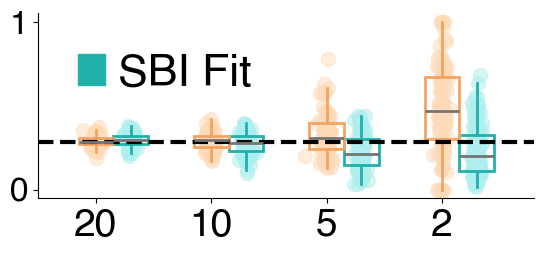

In [20]:
fig,ax = plt.subplots(figsize=(6.4,2.4))
y_data = np.array([FA20_SBI,FA10_SBI,FA5_SBI,FA2_SBI])
g_pos = np.array([1.3,2.3,3.3,4.3])

colors = ['lightseagreen','lightseagreen','lightseagreen','lightseagreen']
colors2 = ['paleturquoise','paleturquoise','paleturquoise','paleturquoise']

BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.3,scatter=True)

g_pos = np.array([1,2,3,4])
colors = ['sandybrown','sandybrown','sandybrown','sandybrown']
colors2 = ['peachpuff','peachpuff','peachpuff','peachpuff']
y_data = np.array([FA20,FA10,FA5,FA2])
BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.3,scatter=True)

l = plt.axhline(FracAni(dt_evals,np.mean(dt_evals)),c='k',lw=3,ls='--',label='True FA')
plt.xticks([1,2,3,4],[20,10,5,2],fontsize=28)
plt.xticks(fontsize=28)
#plt.xlabel('SNR',fontsize=32)
#plt.ylabel('FA',fontsize=32)
leg_patch1 = mpatches.Patch(color='lightseagreen', label='SBI Fit')
leg_patch2 = mpatches.Patch(color='sandybrown', label='NLLS Fit')
ax.legend(
    handles=[leg_patch1],
    loc='upper left',         # base location  # fine-tune the legend's position
    frameon=False, ncols=1,
fontsize=32,columnspacing=0.3,handlelength=0.6,handletextpad=0.3,bbox_to_anchor=(0,1))
plt.yticks([0,1])
if Save: plt.savefig(FigLoc+'EgNoiseFA.pdf',format='pdf',bbox_inches='tight',transparent=True)

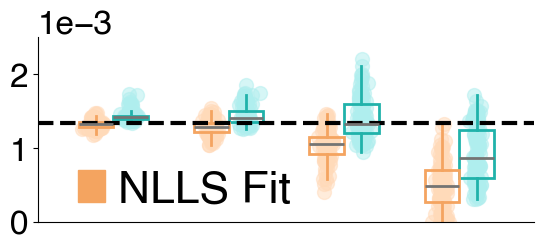

In [21]:
fig,ax = plt.subplots(figsize=(6.4,2.4))
y_data = np.array([MD20_SBI,MD10_SBI,MD5_SBI,MD2_SBI])
g_pos = np.array([1.3,2.3,3.3,4.3])

colors = ['lightseagreen','lightseagreen','lightseagreen','lightseagreen']
colors2 = ['paleturquoise','paleturquoise','paleturquoise','paleturquoise']

BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.3,scatter=True)

g_pos = np.array([1,2,3,4])
colors = ['sandybrown','sandybrown','sandybrown','sandybrown']
colors2 = ['peachpuff','peachpuff','peachpuff','peachpuff']
y_data = np.array([MD20,MD10,MD5,MD2])
BoxPlots(y_data,g_pos,colors,colors2,ax,widths=0.3,scatter=True)

l = plt.axhline(np.mean(dt_evals),c='k',lw=3,ls='--',label='True MD')
plt.xticks([])
#plt.xticks(fontsize=28)
#plt.xlabel('SNR',fontsize=32)
#plt.ylabel('MD',fontsize=32)
leg_patch2 = mpatches.Patch(color='sandybrown', label='NLLS Fit')
ax.legend(
    handles=[leg_patch2],
    loc='upper left',         # base location  # fine-tune the legend's position
    frameon=False, ncols=1,
fontsize=32,columnspacing=0.3,handlelength=0.6,handletextpad=0.3,bbox_to_anchor=(0,0.5))
plt.yticks([0,0.001,0.002])
plt.ylim((0, 0.0025))
plt.gca().ticklabel_format(axis='y',style='sci',scilimits=(-1,1))
if Save: plt.savefig(FigLoc+'EgNoiseMD.pdf',format='pdf',bbox_inches='tight',transparent=True)

## c

In [22]:
torch.manual_seed(10)
SNR = NoiseLevels
ErrorFull = []
NoiseApproxFull = []
for k in tqdm(range(5)):
    ErrorN2 = []
    ENoise = []
    for i in range(500):
        tparams = mat_to_vals(DTISim[i])
        tObs = Samples[k,:,i]#Simulator(bvals,bvecs,200,params,Noise)
        mat_true = vals_to_mat(tparams)
        evals_true,evecs_true = np.linalg.eigh(mat_true)
        true_signal_dti = single_tensor(gtabSimF, S0=200, evals=evals_true, evecs=evecs_true,
                           snr=None)
        posterior_samples_1 = posteriorFull.sample((InferSamples,), x=tObs,show_progress_bars=False)
        mat_guess = vals_to_mat([histogram_mode(p) for p in posterior_samples_1.T])
        mat_guess = clip_negative_eigenvalues(mat_guess)
        ErrorN2.append(Errors(mat_guess,mat_true,gtabSimF,true_signal_dti,tObs))
        ENoise.append(posterior_samples_1[:,-1].mean())
    NoiseApproxFull.append(ENoise)
    ErrorFull.append(ErrorN2)

NoiseApproxFull = np.array(NoiseApproxFull)    

Error_s = []
for k,gtab,Samps,DTIS in zip([65,20,7],[gtabSimF,gtabSim20,gtabSim7],[Samples,Samples20,Samples7],[DTISim,DTISim20,DTISim7]):
    tenmodel = dti.TensorModel(gtab,fit_method='NLLS')
    Error_n = []
    for S,Noise in zip(Samps,NoiseLevels):
        Error = []
        for i in range(500):
            tenfit = tenmodel.fit(S[:,i])
            tensor_vals = dti.lower_triangular(tenfit.quadratic_form)
            DT_test = vals_to_mat(tensor_vals)
            Error.append(Errors(DT_test,DTIS[i],gtab,Samps[0][:,i],S[:,i]))
        Error_n.append(Error)
    Error_s.append(Error_n)
Error_s = np.array(Error_s)
Error_s = np.swapaxes(Error_s,0,1)

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/maximilianeggl/Dropbox/PostDoc/Silvia/SBIDTIPaper2/Code/dwMRI_BasicFuncs.py:100: RuntimeWarning: invalid value encountered in scalar divide
  return numerator / denominator
/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


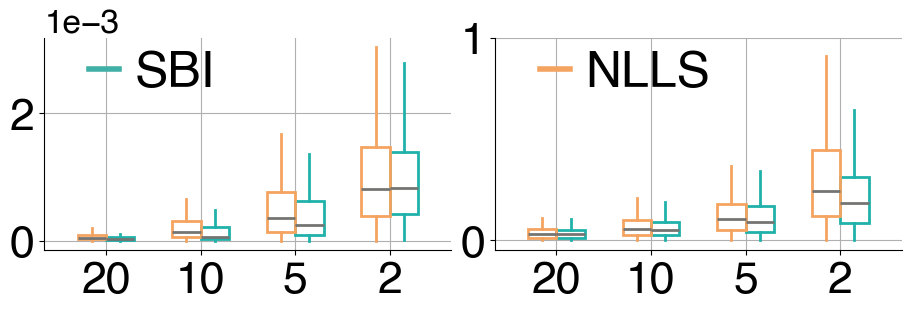

In [23]:
fig,axs = plt.subplots(1,2,figsize=(9,3),constrained_layout=True)
ax = axs.ravel()
for ll,(a,E,t) in enumerate(zip(ax,np.array(ErrorFull).T,Errors_name)):
    y_data = E[:,1:]
    g_pos = np.array([1.3,2.3,3.3,4.3])
    colors = ['lightseagreen','lightseagreen','lightseagreen','lightseagreen']
    colors2 = ['paleturquoise','paleturquoise','paleturquoise','paleturquoise']
    
    BoxPlots(y_data.T,g_pos,colors,colors2,a,widths=0.3,scatter=False)
    y_data = Error_s[1:,0,:,ll].T
    g_pos = np.array([1,2,3,4])
    colors = ['sandybrown','sandybrown','sandybrown','sandybrown']
    colors2 = ['peachpuff','peachpuff','peachpuff','peachpuff']
    
    BoxPlots(y_data.T,g_pos,colors,colors2,a,widths=0.3,scatter=False)


    plt.sca(a)
    if(ll>3):
        plt.xlabel('SNR', fontsize=24)
    plt.xticks([1.15, 2.15, 3.15, 4.15,], NoiseLevels[1:])
    #ymax = max(bp2['whiskers'][1].get_ydata()[1],bp['whiskers'][1].get_ydata()[1])*1.2
    # Create custom legend handles
    plt.gca().ticklabel_format(axis='y',style='sci',scilimits=(-1,1))
    plt.yticks(fontsize=32)
    plt.xticks([1.15, 2.15, 3.15, 4.15,], NoiseLevels[1:],fontsize=32)

    if(ll==0):
        handles = [
            Line2D([0], [0], color=SBIFit, lw=4, label='SBI'),  # Adjust color as per the actual plot color
        ]
        # Add the legenda
        plt.legend(handles=handles,loc=2, bbox_to_anchor=(0,1.15),
                   fontsize=36,columnspacing=0.3,handlelength=0.6,handletextpad=0.3)
    if(ll==1):
        handles = [
            Line2D([0], [0], color=WLSFit, lw=4, label='NLLS'),  # Adjust color as per the actual plot color
        ]
        # Add the legenda
        plt.legend(handles=handles,loc=2, bbox_to_anchor=(0,1.15),
                   fontsize=36,columnspacing=0.3,handlelength=0.6,handletextpad=0.3)
        plt.ylim([-0.05,1])
        plt.yticks([0,1])
    plt.grid()

if Save: plt.savefig(FigLoc+'SimDatDTIErrors1.pdf',format='pdf',bbox_inches='tight',transparent=True)

## d

In [24]:
np.random.seed(1)
torch.manual_seed(1)
if os.path.exists(f"{network_path}/DTISimMin.pickle"):
    with open(f"{network_path}/DTISimMin.pickle", "rb") as handle:
        posterior7 = pickle.load(handle)
else:
    Obs = []
    Par = []
    for i in tqdm(range(TrainingSamples)):
        params = priorNoise.sample()
        dt = ComputeDTI(params)
        dt = ForceLowFA(dt)
        a = params[-1]
        Obs.append(CustomSimulator(dt,gtabSim7,200,a))
        Par.append(np.hstack([mat_to_vals(dt),a]))
    
    Obs = np.array(Obs)
    Par = np.array(Par)
    Obs = torch.tensor(Obs).float()
    Par = torch.tensor(Par).float()
    
    # Create inference object. Here, NPE is used.
    inference = SNPE(prior=priorNoise)
    
    # generate simulations and pass to the inference object
    inference = inference.append_simulations(Par, Obs)
    
    # train the density estimator and build the posterior
    density_estimator = inference.train()
    posterior7 = inference.build_posterior(density_estimator)
    if not os.path.exists(f"{network_path}/DTISimMin.pickle"):
        with open(f"{network_path}/DTISimMin.pickle", "wb") as handle:
            pickle.dump(posterior7, handle)

In [25]:
torch.manual_seed(10)
SNR = NoiseLevels
Error7 = []
NoiseApprox7 = []
for k in tqdm(range(5)):
    ErrorN2 = []
    ENoise = []
    for i in range(500):
        tparams = mat_to_vals(DTISim7[i])
        tObs = Samples7[k,:,i]
        mat_true = vals_to_mat(tparams)
        evals_true,evecs_true = np.linalg.eigh(mat_true)
        true_signal_dti = single_tensor(gtabSim7, S0=200, evals=evals_true, evecs=evecs_true,
                           snr=None)
        posterior_samples_1 = posterior7.sample((InferSamples,), x=tObs,show_progress_bars=False)
        mat_guess = vals_to_mat(np.array(posterior_samples_1.mean(axis=0)))
        ErrorN2.append(Errors(mat_guess,mat_true,gtabSim7,true_signal_dti,tObs))
        ENoise.append(posterior_samples_1[:,-1].mean())
    NoiseApprox7.append(ENoise)
    Error7.append(ErrorN2)

NoiseApprox7 = np.array(NoiseApprox7)    


  0%|          | 0/5 [00:00<?, ?it/s]

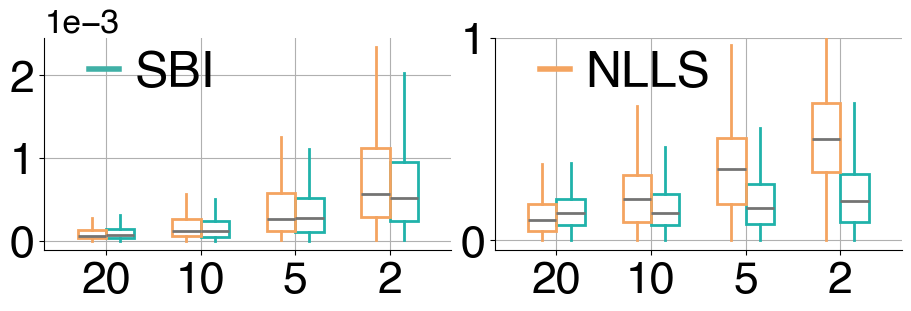

In [27]:
fig,axs = plt.subplots(1,2,figsize=(9,3),constrained_layout=True)
ax = axs.ravel()
for ll,(a,E,t) in enumerate(zip(ax,np.array(Error7).T,Errors_name)):
    y_data = E[:,1:]
    g_pos = np.array([1.3,2.3,3.3,4.3])
    colors = ['lightseagreen','lightseagreen','lightseagreen','lightseagreen']
    colors2 = ['paleturquoise','paleturquoise','paleturquoise','paleturquoise']
    
    BoxPlots(y_data.T,g_pos,colors,colors2,a,widths=0.3,scatter=False)
    y_data = Error_s[1:,-1,:,ll].T
    g_pos = np.array([1,2,3,4])
    colors = ['sandybrown','sandybrown','sandybrown','sandybrown']
    colors2 = ['peachpuff','peachpuff','peachpuff','peachpuff']
    
    BoxPlots(y_data.T,g_pos,colors,colors2,a,widths=0.3,scatter=False)




    plt.sca(a)
    if(ll>3):
        plt.xlabel('SNR', fontsize=24)
    plt.xticks([1.15, 2.15, 3.15, 4.15,], NoiseLevels[1:])
    #ymax = max(bp2['whiskers'][1].get_ydata()[1],bp['whiskers'][1].get_ydata()[1])*1.2
    # Create custom legend handles
    plt.gca().ticklabel_format(axis='y',style='sci',scilimits=(-1,1))
    plt.yticks(fontsize=32)
    plt.xticks([1.15, 2.15, 3.15, 4.15,], NoiseLevels[1:],fontsize=32)

    if(ll==0):
        handles = [
            Line2D([0], [0], color=SBIFit, lw=4, label='SBI'),  # Adjust color as per the actual plot color
        ]
        # Add the legenda
        plt.legend(handles=handles,loc=2, bbox_to_anchor=(0,1.15),
                   fontsize=36,columnspacing=0.3,handlelength=0.6,handletextpad=0.3)
    if(ll==1):
        handles = [
            Line2D([0], [0], color=WLSFit, lw=4, label='NLLS'),  # Adjust color as per the actual plot color
        ]
        # Add the legenda
        plt.legend(handles=handles,loc=2, bbox_to_anchor=(0,1.15),
                   fontsize=36,columnspacing=0.3,handlelength=0.6,handletextpad=0.3)
        plt.ylim([-0.05,1])
        plt.yticks([0,1])
    plt.grid()
#plt.tight_layout()

if Save: plt.savefig(FigLoc+'SimDatDTIErrors2.pdf',format='pdf',bbox_inches='tight',transparent=True)

## e

In [28]:
fimg_init, fbvals, fbvecs = get_fnames('small_64D')
bvals, bvecs = read_bvals_bvecs(fbvals, fbvecs)
hsph_initial = HemiSphere(xyz=bvecs[1:])
hsph_updated,_ = disperse_charges(hsph_initial,5000)
bvecs = np.vstack([[0,0,0],hsph_updated.vertices])
bvalsExt = np.hstack([bvals, 3000*np.ones_like(bvals)])
bvecsExt = np.vstack([bvecs, bvecs])
bvalsExt[65] = 0
gtabSim = gradient_table(bvalsExt, bvecsExt)

In [29]:
if os.path.exists(f"{network_path}/DKISimFull.pickle"):
    with open(f"{network_path}/DKISimFull.pickle", "rb") as handle:
        posteriorFull = pickle.load(handle)
else:
    torch.manual_seed(1)
    np.random.seed(1)
    DT = []
    KT = []
    S0 = []
    DT1,KT1 = GenDTKT([DT1_full,DT2_full],[x4_full,R1_full,x2_full,R2_full],12,int(2.5*6000))
    DT2,KT2 = GenDTKT([DT1_lfa,DT2_lfa],[x4_lfa,R1_lfa,x2_lfa,R2_lfa],12,int(2.5*2000))
    DT3,KT3 = GenDTKT([DT1_hfa,DT2_hfa],[x4_hfa,R1_hfa,x2_hfa,R2_hfa],12,int(2.5*6000))
    DT4,KT4 = GenDTKT([DT1_ulfa,DT2_ulfa],[x4_ulfa,R1_ulfa,x2_ulfa,R2_ulfa],12,int(2.5*6000))
    DT5,KT5 = GenDTKT([DT1_hak,DT2_hak],[x4_hak,R1_hak,x2_hak,R2_hak],12,int(2.5*6000))
    
    
    DT = np.vstack([DT1,DT2,DT3,DT4,DT5])
    KT = np.vstack([KT1,KT2,KT3,KT4,KT5])
    
    S0 = np.array(S0).reshape(len(S0),1)
    
    indx = np.arange(len(KT))
    Obs = np.zeros([len(KT),len(gtabSim.bvecs)])
    kk = 0
    while len(indx)>0:
        for i in tqdm(indx): 
            Obs[i] = CustomDKISimulator(DT[i],KT[i],gtabSim,200,np.random.rand()*30)
        
        indxNew = []
        for i,O in enumerate(Obs):
            if (O>800).any() or (O<0).any():
                indxNew.append(i)
        KT[indxNew] = KT[indxNew]/2
        DT[indxNew] = GenDTKT([DT1_full,DT2_full],[x4_full,R1_full,x2_full,R2_full],kk,1)[0]
    
        indx = indxNew
        kk+=1
    Par = np.hstack([DT,KT])
    Obs = torch.tensor(Obs).float()
    Par = torch.tensor(Par).float()
    
    # Create inference object. Here, NPE is used.
    inference = SNPE()
    
    # generate simulations and pass to the inference object
    inference = inference.append_simulations(Par, Obs)
    
    # train the density estimator and build the posterior
    density_estimator = inference.train(stop_after_epochs= 100)
    posteriorFull = inference.build_posterior(density_estimator)
    
    os.system('say "Network done."')
    if not os.path.exists(f"{network_path}/DKISimFull.pickle"):
        with open(f"{network_path}/DKISimFull.pickle", "wb") as handle:
            pickle.dump(posteriorFull, handle)

In [30]:
torch.manual_seed(2)
np.random.seed(2)
j = 1
vL = torch.tensor([0.2*j])
vS = torch.tensor([0.01*j])  

kk = np.random.randint(0,4)
if(kk==0):
    DT,KT = GenDTKT([DT1_full,DT2_full],[x4_full,R1_full,x2_full,R2_full],2,1)
elif(kk==1):
    DT,KT = GenDTKT([DT1_lfa,DT2_lfa],[x4_lfa,R1_lfa,x2_lfa,R2_lfa],2,1)
elif(kk==2):
    DT,KT = GenDTKT([DT1_hfa,DT2_hfa],[x4_hfa,R1_hfa,x2_hfa,R2_hfa],2,1)
elif(kk==3):
    DT,KT = GenDTKT([DT1_ulfa,DT2_ulfa],[x4_ulfa,R1_ulfa,x2_ulfa,R2_ulfa],2,1)

tObs = CustomDKISimulator(DT.squeeze(),KT.squeeze(),gtabSim,200,20)
tTrue = CustomDKISimulator(DT.squeeze(),KT.squeeze(),gtabSim,200,None)

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

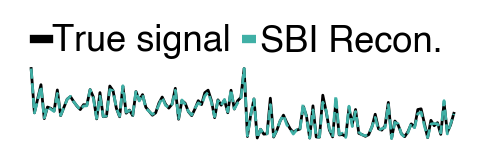

In [31]:
torch.manual_seed(1)
np.random.seed(1)
posterior_samples_1 = posteriorFull.sample((InferSamples,), x=tObs,show_progress_bars=True)
GuessDKI = posterior_samples_1.mean(axis=0)
GuessSig = CustomDKISimulator(GuessDKI[:6],GuessDKI[6:],gtabSim,200)
plt.subplots(figsize=(6,1))
plt.plot(tTrue,lw=2,c='k',label='True signal')
plt.plot(GuessSig,lw=2,c=SBIFit,ls='--',label='SBI Recon.')
plt.axis('off')
legend = plt.legend(ncols=2,loc=1,bbox_to_anchor =  (1,1.95),fontsize=26,columnspacing=0.3,handlelength=0.4,handletextpad=0.1)
for handle in legend.get_lines():
    handle.set_linewidth(6)  # Set desired linewidth
if Save: plt.savefig(FigLoc+'FullReconSBI.pdf',format='pdf',bbox_inches='tight',transparent=True)

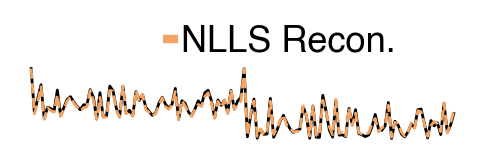

In [32]:
dkimodel = dki.DiffusionKurtosisModel(gtabSim,fit_method='NLLS')
tenfit = dkimodel.fit(tObs)
plt.subplots(figsize=(6,1))
plt.plot(tTrue,lw=2,c='k')
plt.plot(tenfit.predict(gtabSim,200),lw=2,c=WLSFit,ls='--',label='NLLS Recon.')
plt.axis('off')
legend = plt.legend(ncols=2,loc=1,bbox_to_anchor =  (0.9,1.95),fontsize=26,columnspacing=0.3,handlelength=0.4,handletextpad=0.1)
for handle in legend.get_lines():
    handle.set_linewidth(6)  # Set desired linewidth
if Save: plt.savefig(FigLoc+'FullReconWLS.pdf',format='pdf',bbox_inches='tight',transparent=True)

In [33]:
torch.manual_seed(1)
np.random.seed(1)
DT1,KT1 = GenDTKT([DT1_full,DT2_full],[x4_full,R1_full,x2_full,R2_full],1,40)
DT2,KT2 = GenDTKT([DT1_lfa,DT2_lfa],[x4_lfa,R1_lfa,x2_lfa,R2_lfa],1,40)
DT3,KT3 = GenDTKT([DT1_hfa,DT2_hfa],[x4_hfa,R1_hfa,x2_hfa,R2_hfa],1,40)
DT4,KT4 = GenDTKT([DT1_ulfa,DT2_ulfa],[x4_ulfa,R1_ulfa,x2_ulfa,R2_ulfa],1,40)
DT5,KT5 = GenDTKT([DT1_hak,DT2_hak],[x4_hak,R1_hak,x2_hak,R2_hak],12,40)

SampsDT = np.vstack([DT1,DT2,DT3,DT4,DT5])
SampsKT = np.vstack([KT1,KT2,KT3,KT4,KT5])

Samples  = []

for Sd,Sk in zip(SampsDT,SampsKT):
    Samples.append([CustomDKISimulator(Sd,Sk,gtabSim, S0=200,snr=scale) for scale in NoiseLevels])

Samples = np.array(Samples)

In [34]:
torch.manual_seed(10)
ErrorFull = []
for k in tqdm(range(5)):
    ErrorN2 = []
    ENoise = []
    for i in range(200):
        tObs = Samples[i,k,:]
        posterior_samples_1 = posteriorFull.sample((InferSamples,), x=tObs,show_progress_bars=False)
        GuessSBI = posterior_samples_1.mean(axis=0)
        
        ErrorN2.append(DKIErrors(GuessSBI[:6],GuessSBI[6:],SampsDT[i],SampsKT[i]))
    ErrorFull.append(ErrorN2)

Error_s = []
dkimodel = dki.DiffusionKurtosisModel(gtabSim,fit_method='NLLS')

for k in tqdm(range(5)):
    ErrorN2 = []
    ENoise = []
    for i in range(200):
        tObs = Samples[i,k,:]#Simulator(bvals,bvecs,200,params,Noise)
        tenfit = dkimodel.fit(tObs)
        
        ErrorN2.append(DKIErrors(tenfit.lower_triangular(),tenfit.kt,SampsDT[i],SampsKT[i]))
    Error_s.append(ErrorN2)



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/dipy/reconst/dti.py:1826: RuntimeWarning: divide by zero encountered in divide
  params[vox, 12:] = this_param[6:-1] / md2
/Users/maximilianeggl/Dropbox/PostDoc/Silvia/SBIDTIPaper2/Code/dwMRI_BasicFuncs.py:267: RuntimeWarning: invalid value encountered in subtract
  (Wxxxx - W) ** 2
/Users/maximilianeggl/Dropbox/PostDoc/Silvia/SBIDTIPaper2/Code/dwMRI_BasicFuncs.py:268: RuntimeWarning: invalid value encountered in subtract
  + (Wyyyy - W) ** 2
/Users/maximilianeggl/Dropbox/PostDoc/Silvia/SBIDTIPaper2/Code/dwMRI_BasicFuncs.py:269: RuntimeWarning: invalid value encountered in subtract
  + (Wzzzz - W) ** 2
/Users/maximilianeggl/Dropbox/PostDoc/Silvia/SBIDTIPaper2/Code/dwMRI_BasicFuncs.py:271: RuntimeWarning: invalid value encountered in subtract
  + 6 * ((Wxxyy - W / 3) ** 2 + (Wxxzz - W / 3) ** 2 + (Wyyzz - W / 3) ** 2)


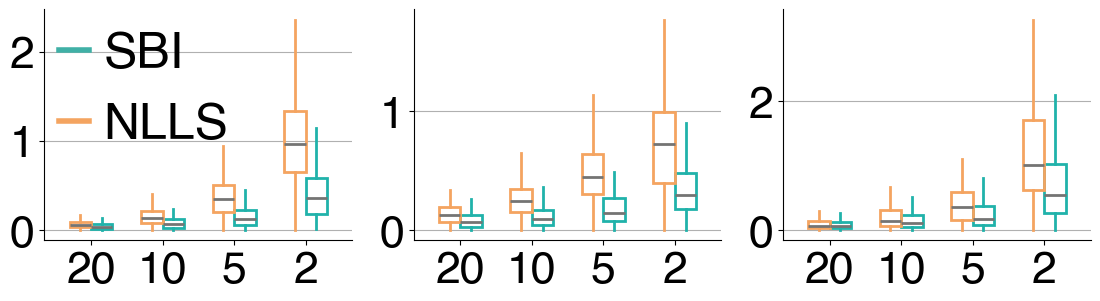

In [35]:
ErrorFull = np.array(ErrorFull)
Error_s = np.array(Error_s)
ErrorNames = ['MK Error', 'AK Error', 'RK Error', 'MKT Error', 'KFA Error']
fig,ax = plt.subplots(1,3,figsize=(13.5,3))
for i in range(3):
    plt.sca(ax[i])
    g_pos = np.array([1.3,2.3,3.3,4.3])
    colors = ['lightseagreen','lightseagreen','lightseagreen','lightseagreen']
    colors2 = ['paleturquoise','paleturquoise','paleturquoise','paleturquoise']
    BoxPlots(ErrorFull[1:,:,i],g_pos,colors,colors2,ax[i],widths=0.3,scatter=False)
    g_pos = np.array([1,2,3,4])
    colors = ['sandybrown','sandybrown','sandybrown','sandybrown']
    colors2 = ['peachpuff','peachpuff','peachpuff','peachpuff']
    BoxPlots(Error_s[1:,:,i],g_pos,colors,colors2,ax[i],widths=0.3,scatter=False)
    plt.xticks([1.15, 2.15, 3.15, 4.15,],[20,10,5,2],fontsize=32)
    plt.gca().ticklabel_format(axis='y',style='sci',scilimits=(-1,1))
    plt.grid(axis='y')
    plt.yticks(fontsize=32)
    
    if(i==0):
        handles = [
            Line2D([0], [0], color=SBIFit, lw=4, label='SBI'),Line2D([0], [0], color=WLSFit, lw=4, label='NLLS'),  # Adjust color as per the actual plot color
        ]
        # Add the legenda
        plt.legend(handles=handles,loc=2, bbox_to_anchor=(-0.1,1.1),
                   fontsize=36,columnspacing=0.3,handlelength=0.6,handletextpad=0.3)

if Save: plt.savefig(FigLoc+'ErrorsFull.pdf',format='pdf',bbox_inches='tight',transparent=True)

## f

In [36]:
fimg_init, fbvals, fbvecs = get_fnames('small_64D')
bvals, bvecs = read_bvals_bvecs(fbvals, fbvecs)
hsph_initial15 = HemiSphere(xyz=bvecs[1:16])
hsph_initial7 = HemiSphere(xyz=bvecs[1:7])
hsph_updated15,_ = disperse_charges(hsph_initial15,5000)
hsph_updated7,_ = disperse_charges(hsph_initial7,5000)
gtabSimSub = gradient_table(np.array([0]+[1000]*6+[3000]*15).squeeze(), np.vstack([[0,0,0],hsph_updated7.vertices,hsph_updated15.vertices]))

In [37]:
if os.path.exists(f"{network_path}/DKISimMin.pickle"):
    with open(f"{network_path}/DKISimMin.pickle", "rb") as handle:
        posteriorFull = pickle.load(handle)
else:
    torch.manual_seed(1)
    np.random.seed(1)
    DT = []
    KT = []
    S0 = []
    DT1,KT1 = GenDTKT([DT1_full,DT2_full],[x4_full,R1_full,x2_full,R2_full],12,int(2.5*6000))
    DT2,KT2 = GenDTKT([DT1_lfa,DT2_lfa],[x4_lfa,R1_lfa,x2_lfa,R2_lfa],12,int(2.5*2000))
    DT3,KT3 = GenDTKT([DT1_hfa,DT2_hfa],[x4_hfa,R1_hfa,x2_hfa,R2_hfa],12,int(2.5*6000))
    DT4,KT4 = GenDTKT([DT1_ulfa,DT2_ulfa],[x4_ulfa,R1_ulfa,x2_ulfa,R2_ulfa],12,int(2.5*6000))
    DT5,KT5 = GenDTKT([DT1_hak,DT2_hak],[x4_hak,R1_hak,x2_hak,R2_hak],12,int(2.5*6000))
    
    
    DT = np.vstack([DT1,DT2,DT3,DT4,DT5])
    KT = np.vstack([KT1,KT2,KT3,KT4,KT5])
    
    S0 = np.array(S0).reshape(len(S0),1)
    
    indx = np.arange(len(KT))
    Obs = np.zeros([len(KT),len(gtabSimSub.bvecs)])
    kk = 0
    while len(indx)>0:
        for i in tqdm(indx): 
            Obs[i] = CustomDKISimulator(DT[i],KT[i],gtabSimSub,200,np.random.rand()*30)
        
        indxNew = []
        for i,O in enumerate(Obs):
            if (O>800).any() or (O<0).any():
                indxNew.append(i)
        KT[indxNew] = KT[indxNew]/2
        DT[indxNew] = GenDTKT([DT1_full,DT2_full],[x4_full,R1_full,x2_full,R2_full],kk,1)[0]
    
        indx = indxNew
        kk+=1
    Par = np.hstack([DT,KT])
    Obs = torch.tensor(Obs).float()
    Par = torch.tensor(Par).float()
    
    # Create inference object. Here, NPE is used.
    inference = SNPE()
    
    # generate simulations and pass to the inference object
    inference = inference.append_simulations(Par, Obs)
    
    # train the density estimator and build the posterior
    density_estimator = inference.train(stop_after_epochs= 100)
    posteriorFull = inference.build_posterior(density_estimator)
    
    os.system('say "Network done."')
    if not os.path.exists(f"{network_path}/DKISimMin.pickle"):
        with open(f"{network_path}/DKISimMin.pickle", "wb") as handle:
            pickle.dump(posteriorFull, handle)

In [38]:
torch.manual_seed(2)
np.random.seed(2)
j = 1
vL = torch.tensor([0.2*j])
vS = torch.tensor([0.01*j])  

kk = np.random.randint(0,4)
if(kk==0):
    DT,KT = GenDTKT([DT1_full,DT2_full],[x4_full,R1_full,x2_full,R2_full],2,1)
elif(kk==1):
    DT,KT = GenDTKT([DT1_lfa,DT2_lfa],[x4_lfa,R1_lfa,x2_lfa,R2_lfa],2,1)
elif(kk==2):
    DT,KT = GenDTKT([DT1_hfa,DT2_hfa],[x4_hfa,R1_hfa,x2_hfa,R2_hfa],2,1)
elif(kk==3):
    DT,KT = GenDTKT([DT1_ulfa,DT2_ulfa],[x4_ulfa,R1_ulfa,x2_ulfa,R2_ulfa],2,1)

tObs = CustomDKISimulator(np.squeeze(DT),np.squeeze(KT),gtabSimSub,200,20)
tTrue = CustomDKISimulator(np.squeeze(DT),np.squeeze(KT),gtabSim,200,None)

In [39]:
torch.manual_seed(1)
np.random.seed(1)
posterior_samples_1 = posteriorFull.sample((InferSamples,), x=tObs,show_progress_bars=True)

Drawing 500 posterior samples:   0%|          | 0/500 [00:00<?, ?it/s]

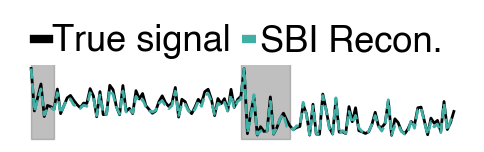

In [40]:
GuessDKI = posterior_samples_1.mean(axis=0)
GuessSig = CustomDKISimulator(GuessDKI[:6],GuessDKI[6:],gtabSim,200)
plt.subplots(figsize=(6,1))
plt.plot(tTrue,lw=2,c='k',label='True signal')
plt.plot(GuessSig,lw=2,c=SBIFit,ls='--',label='SBI Recon.')
plt.axis('off')
plt.fill_betweenx(np.arange(0,500,50),0*np.ones(10),7*np.ones(10),color='gray',alpha=0.5)
plt.fill_betweenx(np.arange(0,500,50),64*np.ones(10),79*np.ones(10),color='gray',alpha=0.5)
plt.ylim(-9.996985449425491, 209.99985644997255)
legend = plt.legend(ncols=2,loc=1,bbox_to_anchor =  (1,1.95),fontsize=26,columnspacing=0.3,handlelength=0.4,handletextpad=0.1)
for handle in legend.get_lines():
    handle.set_linewidth(6)  # Set desired linewidth
if Save: plt.savefig(FigLoc+'7ReconSBI.pdf',format='pdf',bbox_inches='tight',transparent=True)

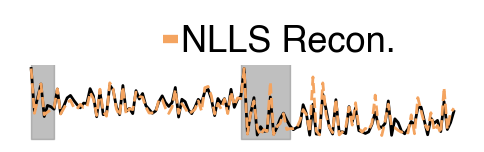

In [41]:
dkimodel = dki.DiffusionKurtosisModel(gtabSimSub,fit_method='NLLS')
tenfit = dkimodel.fit(tObs)
plt.subplots(figsize=(6,1))
plt.plot(tTrue,lw=2,c='k')
plt.plot(tenfit.predict(gtabSim,200),lw=2,c=WLSFit,ls='--',label='NLLS Recon.')
plt.axis('off')
legend = plt.legend(ncols=2,loc=1,bbox_to_anchor =  (0.9,1.95),fontsize=26,columnspacing=0.3,handlelength=0.4,handletextpad=0.1)
for handle in legend.get_lines():
    handle.set_linewidth(6)  # Set desired linewidth
plt.fill_betweenx(np.arange(0,500,50),0*np.ones(10),7*np.ones(10),color='gray',alpha=0.5)
plt.fill_betweenx(np.arange(0,500,50),64*np.ones(10),79*np.ones(10),color='gray',alpha=0.5)
plt.ylim(-9.996985449425491, 209.99985644997255)
if Save: plt.savefig(FigLoc+'7ReconWLS.pdf',format='pdf',bbox_inches='tight',transparent=True)

In [42]:
torch.manual_seed(1)
np.random.seed(1)

Samples7  = []

for Sd,Sk in zip(SampsDT,SampsKT):
    Samples7.append([CustomDKISimulator(Sd,Sk,gtabSimSub, S0=200,snr=scale) for scale in NoiseLevels])

Samples7 = np.array(Samples7)

In [43]:
torch.manual_seed(10)
ErrorFull = []
for k in tqdm(range(5)):
    ErrorN2 = []
    ENoise = []
    for i in range(200):
        tObs = Samples7[i,k,:]
        posterior_samples_1 = posteriorFull.sample((InferSamples,), x=tObs,show_progress_bars=False)
        GuessSBI = posterior_samples_1.mean(axis=0)
        
        ErrorN2.append(DKIErrors(GuessSBI[:6],GuessSBI[6:],SampsDT[i],SampsKT[i]))
    ErrorFull.append(ErrorN2)

Error_s = []
dkimodel = dki.DiffusionKurtosisModel(gtabSimSub,fit_method='NLLS')

for k in tqdm(range(5)):
    ErrorN2 = []
    ENoise = []
    for i in range(200):
        tObs = Samples7[i,k,:]#Simulator(bvals,bvecs,200,params,Noise)
        tenfit = dkimodel.fit(tObs)
        
        ErrorN2.append(DKIErrors(tenfit.lower_triangular(),tenfit.kt,SampsDT[i],SampsKT[i]))
    Error_s.append(ErrorN2)



  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

/Users/maximilianeggl/miniconda3/envs/SBI_DTI/lib/python3.12/site-packages/dipy/reconst/dti.py:1826: RuntimeWarning: divide by zero encountered in divide
  params[vox, 12:] = this_param[6:-1] / md2
/Users/maximilianeggl/Dropbox/PostDoc/Silvia/SBIDTIPaper2/Code/dwMRI_BasicFuncs.py:267: RuntimeWarning: invalid value encountered in subtract
  (Wxxxx - W) ** 2
/Users/maximilianeggl/Dropbox/PostDoc/Silvia/SBIDTIPaper2/Code/dwMRI_BasicFuncs.py:268: RuntimeWarning: invalid value encountered in subtract
  + (Wyyyy - W) ** 2
/Users/maximilianeggl/Dropbox/PostDoc/Silvia/SBIDTIPaper2/Code/dwMRI_BasicFuncs.py:269: RuntimeWarning: invalid value encountered in subtract
  + (Wzzzz - W) ** 2
/Users/maximilianeggl/Dropbox/PostDoc/Silvia/SBIDTIPaper2/Code/dwMRI_BasicFuncs.py:271: RuntimeWarning: invalid value encountered in subtract
  + 6 * ((Wxxyy - W / 3) ** 2 + (Wxxzz - W / 3) ** 2 + (Wyyzz - W / 3) ** 2)


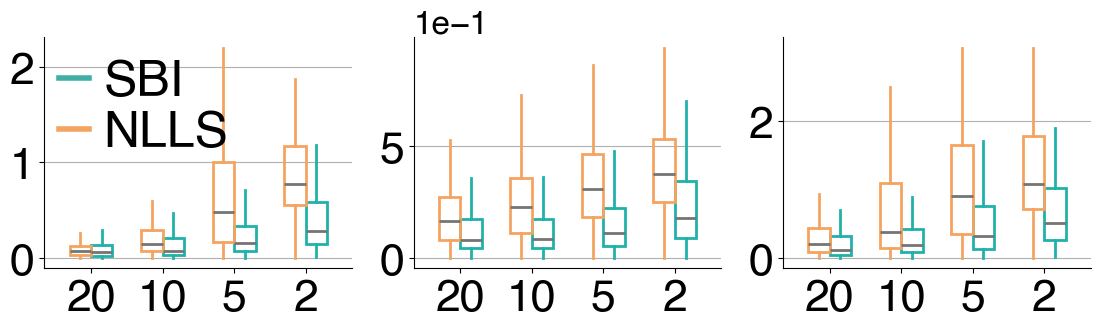

In [44]:
ErrorFull = np.array(ErrorFull)
Error_s = np.array(Error_s)
ErrorNames = ['MK Error', 'AK Error', 'RK Error', 'MKT Error', 'KFA Error']
fig,ax = plt.subplots(1,3,figsize=(13.5,3))
for i in range(3):
    plt.sca(ax[i])
    g_pos = np.array([1.3,2.3,3.3,4.3])
    colors = ['lightseagreen','lightseagreen','lightseagreen','lightseagreen']
    colors2 = ['paleturquoise','paleturquoise','paleturquoise','paleturquoise']
    BoxPlots(ErrorFull[1:,:,i],g_pos,colors,colors2,ax[i],widths=0.3,scatter=False)
    g_pos = np.array([1,2,3,4])
    colors = ['sandybrown','sandybrown','sandybrown','sandybrown']
    colors2 = ['peachpuff','peachpuff','peachpuff','peachpuff']
    BoxPlots(Error_s[1:,:,i],g_pos,colors,colors2,ax[i],widths=0.3,scatter=False)
    plt.xticks([1.15, 2.15, 3.15, 4.15,],[20,10,5,2],fontsize=32)
    plt.gca().ticklabel_format(axis='y',style='sci',scilimits=(-1,1))
    plt.grid(axis='y')
    plt.yticks(fontsize=32)
    if(i==0):
        handles = [
            Line2D([0], [0], color=SBIFit, lw=4, label='SBI'),Line2D([0], [0], color=WLSFit, lw=4, label='NLLS'),  # Adjust color as per the actual plot color
        ]
        # Add the legenda
        plt.legend(handles=handles,loc=2, bbox_to_anchor=(-0.1,1.1),
                   fontsize=36,columnspacing=0.3,handlelength=0.6,handletextpad=0.3,labelspacing=0.1)
if Save: plt.savefig(FigLoc+'ErrorsMin.pdf',format='pdf',bbox_inches='tight',transparent=True)